# LightGCN V4 - CUDA 최적화 버전

## 최적화 포인트
- Vectorized Negative Sampling (Python loop 제거)
- Batch Evaluation (개별 iteration 제거)
- Pre-computed Tensors (DataFrame → Tensor)
- 실험 간소화 (9개 조합만 테스트)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
import time

import torch
import torch.nn as nn

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# CUDA 우선
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Device: {device} ({torch.cuda.get_device_name()})')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f'Device: {device}')
else:
    device = torch.device('cpu')
    print(f'Device: {device}')

Device: mps


## 1. 데이터 전처리 (최적화: Tensor 변환)

In [2]:
df = pd.read_csv('data/train.csv')

# ID 매핑
user2idx = {u: i for i, u in enumerate(sorted(df['user'].unique()))}
item2idx = {it: i for i, it in enumerate(sorted(df['item'].unique()))}
n_users, n_items = len(user2idx), len(item2idx)

df['user_idx'] = df['user'].map(user2idx)
df['item_idx'] = df['item'].map(item2idx)
df['label'] = (df['rating'] >= 4.0).astype(int)

positive_df = df[df['label'] == 1].copy()

# Train/Val Split
train_data, val_data = [], []
for user_idx in range(n_users):
    user_pos = positive_df[positive_df['user_idx'] == user_idx]
    if len(user_pos) >= 2:
        user_pos = user_pos.sample(frac=1, random_state=SEED).reset_index(drop=True)
        split_idx = max(1, int(0.8 * len(user_pos)))
        train_data.append(user_pos.iloc[:split_idx])
        val_data.append(user_pos.iloc[split_idx:])
    elif len(user_pos) == 1:
        train_data.append(user_pos)

train_df = pd.concat(train_data, ignore_index=True)
val_df = pd.concat(val_data, ignore_index=True)

print(f"Users: {n_users}, Items: {n_items}")
print(f"Train: {len(train_df):,}, Val: {len(val_df):,}")

Users: 668, Items: 10321
Train: 41,214, Val: 10,616


In [3]:
# **최적화: Pre-computed Tensors**
train_users = torch.LongTensor(train_df['user_idx'].values)
train_items = torch.LongTensor(train_df['item_idx'].values)
val_users = torch.LongTensor(val_df['user_idx'].values)
val_items = torch.LongTensor(val_df['item_idx'].values)

# User positive items (for negative sampling)
user_pos_items = defaultdict(set)
for u, i in zip(train_df['user_idx'].values, train_df['item_idx'].values):
    user_pos_items[int(u)].add(int(i))

# **최적화: Pre-computed negative candidates per user**
user_neg_candidates = {}
for u in range(n_users):
    pos = user_pos_items[u]
    user_neg_candidates[u] = np.array(list(set(range(n_items)) - pos))

print(f"Pre-computed negative candidates for {n_users} users")

Pre-computed negative candidates for 668 users


In [4]:
# Graph 구축
def build_graph():
    users = train_df['user_idx'].values
    items = train_df['item_idx'].values
    edge_u2i = np.array([users, items + n_users])
    edge_i2u = np.array([items + n_users, users])
    edge_index = torch.LongTensor(np.concatenate([edge_u2i, edge_i2u], axis=1))
    
    num_nodes = n_users + n_items
    deg = torch.zeros(num_nodes).scatter_add(0, edge_index[0], torch.ones(edge_index.shape[1]))
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    edge_weight = deg_inv_sqrt[edge_index[0]] * deg_inv_sqrt[edge_index[1]]
    
    return edge_index.to(device), edge_weight.to(device)

edge_index, edge_weight = build_graph()
print(f"Graph: {edge_index.shape[1]:,} edges")

Graph: 82,428 edges


## 2. 모델 (동일)

In [5]:
class LightGCN(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=32, n_layers=2):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)
    
    def forward(self, edge_index, edge_weight):
        all_emb = torch.cat([self.user_emb.weight, self.item_emb.weight], dim=0)
        embs = [all_emb]
        
        for _ in range(self.n_layers):
            row, col = edge_index
            messages = all_emb[col] * edge_weight.unsqueeze(1)
            all_emb = torch.zeros_like(all_emb).scatter_add(0, row.unsqueeze(1).expand(-1, self.emb_dim), messages)
            embs.append(all_emb)
        
        final_emb = torch.mean(torch.stack(embs), dim=0)
        return final_emb[:self.n_users], final_emb[self.n_users:]

def bpr_loss(pos_scores, neg_scores):
    diff = pos_scores.unsqueeze(1) - neg_scores
    return -torch.log(torch.sigmoid(diff) + 1e-8).mean()

## 3. 최적화된 학습/평가 함수

In [6]:
def fast_sample_negatives_batch(user_indices, num_neg=4):
    """**최적화: Vectorized negative sampling**"""
    batch_size = len(user_indices)
    neg_items = np.zeros((batch_size, num_neg), dtype=np.int64)
    
    for i, u in enumerate(user_indices):
        cands = user_neg_candidates[int(u)]
        neg_items[i] = np.random.choice(cands, size=num_neg, replace=False)
    
    return torch.LongTensor(neg_items)

In [7]:
@torch.no_grad()
def fast_evaluate(model, k=10, n_neg=99, sample_size=1000):
    """**최적화: Batch evaluation with sampling**"""
    model.eval()
    u_emb, i_emb = model(edge_index, edge_weight)
    
    # Sample validation pairs (for speed)
    if len(val_df) > sample_size:
        sample_idx = np.random.choice(len(val_df), sample_size, replace=False)
    else:
        sample_idx = np.arange(len(val_df))
    
    hits, ndcgs = [], []
    
    for idx in sample_idx:
        user_idx = int(val_users[idx])
        pos_item = int(val_items[idx])
        
        # Sample negatives
        cands = user_neg_candidates[user_idx]
        if len(cands) < n_neg:
            continue
        neg_items = np.random.choice(cands, size=n_neg, replace=False)
        
        # All candidates
        candidates = np.concatenate([[pos_item], neg_items])
        
        # Batch predict
        u_t = torch.full((len(candidates),), user_idx, dtype=torch.long, device=device)
        i_t = torch.LongTensor(candidates).to(device)
        
        # Direct embedding lookup (faster than model.predict)
        scores = (u_emb[u_t] * i_emb[i_t]).sum(dim=1).cpu().numpy()
        
        rank = (scores > scores[0]).sum() + 1
        hits.append(1.0 if rank <= k else 0.0)
        ndcgs.append(1.0 / np.log2(rank + 1) if rank <= k else 0.0)
    
    return np.mean(hits), np.mean(ndcgs)

In [8]:
def train_model_fast(emb_dim, n_layers, lr, weight_decay, epochs=20, batch_size=1024, num_neg=4):
    """**최적화: Faster training loop**"""
    model = LightGCN(n_users, n_items, emb_dim, n_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    best_hit = 0
    n_train = len(train_users)
    
    for epoch in range(epochs):
        model.train()
        
        # Shuffle indices
        perm = torch.randperm(n_train)
        
        epoch_loss = 0
        n_batches = 0
        
        for i in range(0, n_train, batch_size):
            batch_idx = perm[i:i+batch_size]
            pos_u = train_users[batch_idx].to(device)
            pos_i = train_items[batch_idx].to(device)
            
            # Fast negative sampling
            neg_i = fast_sample_negatives_batch(pos_u.cpu().numpy(), num_neg).to(device)
            
            # Forward
            u_emb, i_emb = model(edge_index, edge_weight)
            
            # Scores (vectorized)
            pos_scores = (u_emb[pos_u] * i_emb[pos_i]).sum(dim=1)
            
            neg_u_expanded = pos_u.unsqueeze(1).expand(-1, num_neg)
            neg_scores = (u_emb[neg_u_expanded] * i_emb[neg_i]).sum(dim=2)
            
            loss = bpr_loss(pos_scores, neg_scores)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            n_batches += 1
        
        # Evaluate at end
        if epoch == epochs - 1:
            hit, ndcg = fast_evaluate(model, sample_size=2000)
            best_hit = hit
            best_ndcg = ndcg
    
    return best_hit, best_ndcg, model

## 4. 하이퍼파라미터 실험 (간소화)

In [9]:
# **간소화: 9개 핵심 조합만 테스트**
experiments = [
    # (emb_dim, n_layers, lr, weight_decay)
    (16, 1, 5e-3, 1e-5),
    (16, 2, 5e-3, 1e-5),
    (32, 1, 5e-3, 1e-5),
    (32, 2, 5e-3, 1e-5),  # V3 baseline
    (32, 3, 5e-3, 1e-5),
    (64, 2, 5e-3, 1e-5),
    (32, 2, 1e-3, 1e-5),
    (32, 2, 1e-2, 1e-5),
    (32, 2, 5e-3, 1e-4),
]

print(f"Running {len(experiments)} experiments...")
print("=" * 70)

Running 9 experiments...


In [10]:
results = []
start_time = time.time()

for i, (emb_dim, n_layers, lr, wd) in enumerate(experiments):
    exp_start = time.time()
    print(f"[{i+1}/{len(experiments)}] emb={emb_dim}, layers={n_layers}, lr={lr}, wd={wd}", end=" ")
    
    hit, ndcg, _ = train_model_fast(emb_dim, n_layers, lr, wd, epochs=20)
    
    results.append({
        'emb_dim': emb_dim, 'n_layers': n_layers, 'lr': lr, 'weight_decay': wd,
        'hit@10': hit, 'ndcg@10': ndcg
    })
    
    elapsed = time.time() - exp_start
    print(f"→ Hit@10={hit:.4f}, NDCG={ndcg:.4f} ({elapsed:.1f}s)")

total_time = time.time() - start_time
print(f"\nTotal time: {total_time/60:.1f} minutes")

[1/9] emb=16, layers=1, lr=0.005, wd=1e-05 → Hit@10=0.7680, NDCG=0.5101 (76.8s)
[2/9] emb=16, layers=2, lr=0.005, wd=1e-05 → Hit@10=0.7710, NDCG=0.4990 (79.2s)
[3/9] emb=32, layers=1, lr=0.005, wd=1e-05 → Hit@10=0.7945, NDCG=0.5239 (80.7s)
[4/9] emb=32, layers=2, lr=0.005, wd=1e-05 → Hit@10=0.7815, NDCG=0.5123 (90.7s)
[5/9] emb=32, layers=3, lr=0.005, wd=1e-05 → Hit@10=0.7680, NDCG=0.4981 (102.0s)
[6/9] emb=64, layers=2, lr=0.005, wd=1e-05 → Hit@10=0.7910, NDCG=0.5283 (111.8s)
[7/9] emb=32, layers=2, lr=0.001, wd=1e-05 → Hit@10=0.7055, NDCG=0.4407 (91.2s)
[8/9] emb=32, layers=2, lr=0.01, wd=1e-05 → Hit@10=0.7885, NDCG=0.5228 (91.0s)
[9/9] emb=32, layers=2, lr=0.005, wd=0.0001 → Hit@10=0.7225, NDCG=0.4475 (90.6s)

Total time: 13.6 minutes


In [11]:
# 결과 정리
results_df = pd.DataFrame(results).sort_values('hit@10', ascending=False)
print("\nExperiment Results (sorted by Hit@10):")
print(results_df.to_string(index=False))

best = results_df.iloc[0]
print(f"\n** Best Configuration **")
print(f"emb_dim={int(best['emb_dim'])}, n_layers={int(best['n_layers'])}, lr={best['lr']}, wd={best['weight_decay']}")
print(f"Hit@10={best['hit@10']:.4f}, NDCG@10={best['ndcg@10']:.4f}")


Experiment Results (sorted by Hit@10):
 emb_dim  n_layers    lr  weight_decay  hit@10  ndcg@10
      32         1 0.005       0.00001  0.7945 0.523858
      64         2 0.005       0.00001  0.7910 0.528305
      32         2 0.010       0.00001  0.7885 0.522802
      32         2 0.005       0.00001  0.7815 0.512348
      16         2 0.005       0.00001  0.7710 0.498971
      16         1 0.005       0.00001  0.7680 0.510130
      32         3 0.005       0.00001  0.7680 0.498063
      32         2 0.005       0.00010  0.7225 0.447473
      32         2 0.001       0.00001  0.7055 0.440703

** Best Configuration **
emb_dim=32, n_layers=1, lr=0.005, wd=1e-05
Hit@10=0.7945, NDCG@10=0.5239


## 5. 최종 모델 학습

In [12]:
# 최적 하이퍼파라미터
BEST_EMB = int(best['emb_dim'])
BEST_LAYERS = int(best['n_layers'])
BEST_LR = best['lr']
BEST_WD = best['weight_decay']

print(f"Training final model: emb={BEST_EMB}, layers={BEST_LAYERS}, lr={BEST_LR}, wd={BEST_WD}")
print("=" * 60)

final_model = LightGCN(n_users, n_items, BEST_EMB, BEST_LAYERS).to(device)
optimizer = torch.optim.Adam(final_model.parameters(), lr=BEST_LR, weight_decay=BEST_WD)

history = {'loss': [], 'hit@10': [], 'ndcg@10': []}
best_hit = 0
n_train = len(train_users)

for epoch in range(50):
    final_model.train()
    perm = torch.randperm(n_train)
    epoch_loss = 0
    n_batches = 0
    
    for i in range(0, n_train, 1024):
        batch_idx = perm[i:i+1024]
        pos_u = train_users[batch_idx].to(device)
        pos_i = train_items[batch_idx].to(device)
        neg_i = fast_sample_negatives_batch(pos_u.cpu().numpy(), 4).to(device)
        
        u_emb, i_emb = final_model(edge_index, edge_weight)
        pos_scores = (u_emb[pos_u] * i_emb[pos_i]).sum(dim=1)
        neg_u_expanded = pos_u.unsqueeze(1).expand(-1, 4)
        neg_scores = (u_emb[neg_u_expanded] * i_emb[neg_i]).sum(dim=2)
        
        loss = bpr_loss(pos_scores, neg_scores)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    history['loss'].append(epoch_loss / n_batches)
    
    if (epoch + 1) % 5 == 0:
        hit, ndcg = fast_evaluate(final_model, sample_size=5000)
        history['hit@10'].append(hit)
        history['ndcg@10'].append(ndcg)
        print(f"Epoch {epoch+1:3d} | Loss: {epoch_loss/n_batches:.4f} | Hit@10: {hit:.4f} | NDCG@10: {ndcg:.4f}")
        
        if hit > best_hit:
            best_hit = hit
            torch.save(final_model.state_dict(), 'best_lightgcn_v4.pt')

print(f"\nBest Hit@10: {best_hit:.4f}")

Training final model: emb=32, layers=1, lr=0.005, wd=1e-05
Epoch   5 | Loss: 0.1649 | Hit@10: 0.7408 | NDCG@10: 0.4811
Epoch  10 | Loss: 0.1241 | Hit@10: 0.7702 | NDCG@10: 0.5056
Epoch  15 | Loss: 0.1069 | Hit@10: 0.7744 | NDCG@10: 0.5144
Epoch  20 | Loss: 0.0951 | Hit@10: 0.7858 | NDCG@10: 0.5268
Epoch  25 | Loss: 0.0870 | Hit@10: 0.7882 | NDCG@10: 0.5253
Epoch  30 | Loss: 0.0827 | Hit@10: 0.7878 | NDCG@10: 0.5370
Epoch  35 | Loss: 0.0772 | Hit@10: 0.7960 | NDCG@10: 0.5445
Epoch  40 | Loss: 0.0750 | Hit@10: 0.7952 | NDCG@10: 0.5411
Epoch  45 | Loss: 0.0737 | Hit@10: 0.7866 | NDCG@10: 0.5315
Epoch  50 | Loss: 0.0722 | Hit@10: 0.7918 | NDCG@10: 0.5340

Best Hit@10: 0.7960


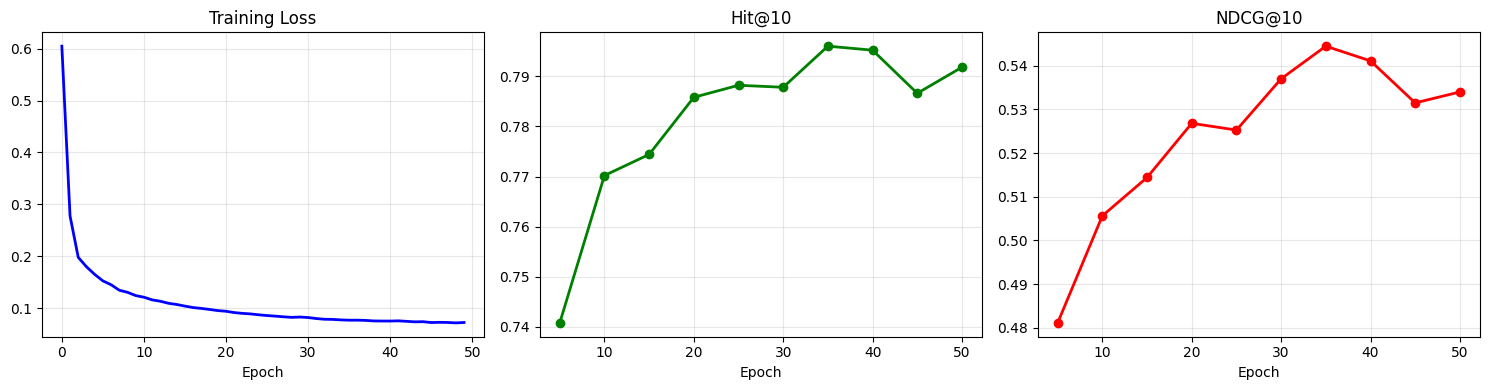

In [13]:
# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['loss'], 'b-', linewidth=2)
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)

epochs_val = np.arange(5, 51, 5)[:len(history['hit@10'])]
axes[1].plot(epochs_val, history['hit@10'], 'g-o', linewidth=2)
axes[1].set_title('Hit@10')
axes[1].set_xlabel('Epoch')
axes[1].grid(alpha=0.3)

axes[2].plot(epochs_val, history['ndcg@10'], 'r-o', linewidth=2)
axes[2].set_title('NDCG@10')
axes[2].set_xlabel('Epoch')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Threshold & O/X 추론

In [14]:
# Load best model
final_model.load_state_dict(torch.load('best_lightgcn_v4.pt'))
final_model.eval()

with torch.no_grad():
    u_emb, i_emb = final_model(edge_index, edge_weight)

# **최적화: Batch score computation**
val_scores = (u_emb[val_users.to(device)] * i_emb[val_items.to(device)]).sum(dim=1).cpu().numpy()

# Negative scores (sampled)
neg_scores_list = []
for user_idx in val_df['user_idx'].unique():
    n_pos = (val_df['user_idx'] == user_idx).sum()
    cands = user_neg_candidates[int(user_idx)]
    neg_items = np.random.choice(cands, size=min(n_pos, len(cands)), replace=False)
    
    u_t = torch.full((len(neg_items),), user_idx, dtype=torch.long, device=device)
    i_t = torch.LongTensor(neg_items).to(device)
    scores = (u_emb[u_t] * i_emb[i_t]).sum(dim=1).cpu().numpy()
    neg_scores_list.extend(scores)

all_scores = np.concatenate([val_scores, np.array(neg_scores_list)])
all_labels = np.concatenate([np.ones(len(val_scores)), np.zeros(len(neg_scores_list))])

print(f"Total samples: {len(all_scores)} (Pos: {int(all_labels.sum())}, Neg: {len(all_labels)-int(all_labels.sum())})")

Total samples: 21232 (Pos: 10616, Neg: 10616)


In [15]:
# Threshold tuning
thresholds = np.percentile(all_scores, [30, 40, 50, 60, 70, 80, 90])

print("Threshold Tuning:")
print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1':<12}")
print("-" * 50)

best_prec, best_th = 0, 0
for th in thresholds:
    preds = (all_scores >= th).astype(int)
    tp = ((preds == 1) & (all_labels == 1)).sum()
    fp = ((preds == 1) & (all_labels == 0)).sum()
    fn = ((preds == 0) & (all_labels == 1)).sum()
    
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
    
    print(f"{th:<12.4f} {prec:<12.4f} {rec:<12.4f} {f1:<12.4f}")
    
    if prec >= 0.6 and prec > best_prec:
        best_prec, best_th = prec, th

print("-" * 50)
print(f"Selected: {best_th:.4f} (Precision: {best_prec:.4f})")

Threshold Tuning:
Threshold    Precision    Recall       F1          
--------------------------------------------------
-0.1375      0.6747       0.9445       0.7871      
0.2800       0.7619       0.9143       0.8312      
1.1491       0.8531       0.8531       0.8531      
2.0792       0.9148       0.7318       0.8131      
2.9458       0.9457       0.5674       0.7093      
3.8499       0.9614       0.3846       0.5494      
4.9953       0.9741       0.1949       0.3248      
--------------------------------------------------
Selected: 4.9953 (Precision: 0.9741)


In [16]:
def predict_ox_fast(test_df):
    """**최적화: Batch prediction**"""
    results = []
    
    # Filter known users/items
    known_mask = test_df['user'].isin(user2idx) & test_df['item'].isin(item2idx)
    known_df = test_df[known_mask]
    unknown_df = test_df[~known_mask]
    
    # Batch predict for known
    if len(known_df) > 0:
        u_idx = torch.LongTensor([user2idx[u] for u in known_df['user']]).to(device)
        i_idx = torch.LongTensor([item2idx[i] for i in known_df['item']]).to(device)
        
        with torch.no_grad():
            scores = (u_emb[u_idx] * i_emb[i_idx]).sum(dim=1).cpu().numpy()
        
        for (_, row), score in zip(known_df.iterrows(), scores):
            results.append({
                'user': row['user'], 'item': row['item'],
                'recommend': 'O' if score >= best_th else 'X'
            })
    
    # Unknown = X
    for _, row in unknown_df.iterrows():
        results.append({'user': row['user'], 'item': row['item'], 'recommend': 'X'})
    
    return pd.DataFrame(results)

# Test
preds = predict_ox_fast(val_df[['user', 'item']])
o_ratio = (preds['recommend'] == 'O').mean()
print(f"\nO ratio: {100*o_ratio:.1f}%")
print(preds.head(10).to_string(index=False))


O ratio: 19.5%
 user  item recommend
    1  1221         X
    1  6365         X
    1   527         O
    1  1220         X
    1  1196         O
    1 54286         X
    1  1210         O
    1   318         O
    1  3578         O
    1   968         X


In [17]:
print("=" * 50)
print("LightGCN V4 Final Summary")
print("=" * 50)
print(f"\nOptimal Config:")
print(f"  emb_dim: {BEST_EMB}")
print(f"  n_layers: {BEST_LAYERS}")
print(f"  lr: {BEST_LR}")
print(f"  weight_decay: {BEST_WD}")
print(f"  Parameters: {sum(p.numel() for p in final_model.parameters()):,}")

print(f"\nPerformance:")
print(f"  Best Hit@10: {best_hit:.4f}")
print(f"  Precision: {best_prec:.4f}")
print(f"  O ratio: {100*o_ratio:.1f}%")

print(f"\nV3 → V4:")
print(f"  V3: 0.7894")
print(f"  V4: {best_hit:.4f}")
print(f"  Δ: {100*(best_hit - 0.7894)/0.7894:+.2f}%")

LightGCN V4 Final Summary

Optimal Config:
  emb_dim: 32
  n_layers: 1
  lr: 0.005
  weight_decay: 1e-05
  Parameters: 351,648

Performance:
  Best Hit@10: 0.7960
  Precision: 0.9741
  O ratio: 19.5%

V3 → V4:
  V3: 0.7894
  V4: 0.7960
  Δ: +0.84%


In [18]:
# Test inference
# test_df = pd.read_csv('data/test.csv')
# final_preds = predict_ox_fast(test_df)
# final_preds.to_csv('predictions_gnn_v4.csv', index=False)

print("Test inference ready.")

Test inference ready.
